In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nlp
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import requests
from bs4 import BeautifulSoup

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load the fake and real news datasets
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

# Remove "(Reuters)" from real news text
df_true["text"] = df_true["text"].replace("(Reuters)","",regex=True)

# Label the datasets: 0 = fake, 1 = real
df_fake["target"] = 0
df_true["target"] = 1

# Drop columns we won't use
df_fake = df_fake.drop(["title","subject","date"],axis = 1)
df_true = df_true.drop(["title","subject","date"],axis = 1)

# Combine both datasets and randomly shuffle the rows
df = pd.concat([df_fake,df_true],axis = 0)
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(["index"], axis = 1, inplace = True)

In [3]:
# Clean and normalize text for analysis
def wordopt(text):
    text = text.lower()                                                 # Lowercase the text
    text = re.sub(r'\[.*?\]', '', text)                                 # Remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)                   # Remove URLs
    text = re.sub(r'<.*?>+', '', text)                                  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)    # Remove punctuation
    text = re.sub(r'\n', '', text)                                      # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)                                # Remove words with numbers
    return text

# Apply preprocessing to all rows
df["text"] = df["text"].apply(wordopt)

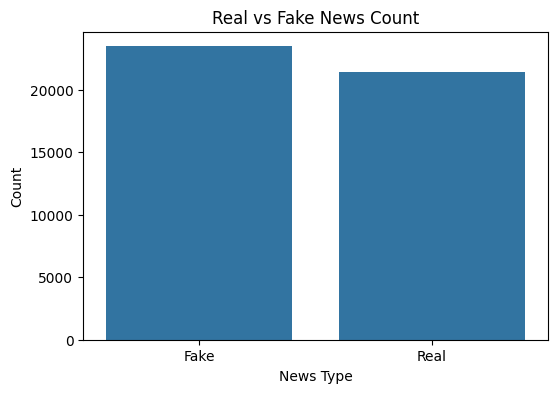

In [4]:
# Plot the number of real vs fake news articles
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Real vs Fake News Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()

In [22]:
# Analysis of news type csv files:
# There is a larger amount of fake news headlines to real news headlines. This could create conflicts and bias with
# our models as they are being trained on datasets with more fake news headlines to real news headlines.

In [6]:
# Split into training and testing sets
X = df["text"]
Y = df["target"]
X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.75)

# Vectorize text using TF-IDF
vectorization = TfidfVectorizer()
analyze = vectorization.build_analyzer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(x_test)

# Train a Logistic Regression model
lr = LogisticRegression()
lr.fit(xv_train,Y_train)

# Evaluate the Logistic Regression model
print("The Accuracy of the Logistic Regression Model is {}".format(lr.score(xv_test,y_test)))
print(classification_report(y_test,lr.predict(xv_test)))

The Accuracy of the Logistic Regression Model is 0.9725307358793134
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17675
           1       0.97      0.98      0.97     15999

    accuracy                           0.97     33674
   macro avg       0.97      0.97      0.97     33674
weighted avg       0.97      0.97      0.97     33674



In [7]:
# Load, clean and vectorize the News dataset for testing
data = pd.read_csv('News.csv',index_col=0)
data = data.drop(["title", "subject","date"], axis = 1)
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)
data["text"] = data["text"].replace("(Reuters)","",regex=True)
data["text"] = data["text"].apply(wordopt)
data.dropna(inplace=True)

sample_test = data.sample(200)
sample_test.reset_index(inplace=True)

sample_x = data["text"]
sample_y = data["class"]

sample_xv = vectorization.transform(sample_x)

# Evaluate the Logistic Regression model using the News dataset
print("The Accuracy of the Logistic Regression Model on dataset News.csv is {}".format(lr.score(sample_xv,sample_y)))

The Accuracy of the Logistic Regression Model on dataset News.csv is 0.9752888532692179


In [8]:
# Train a Decision Tree Classifier model
dtc = DecisionTreeClassifier()
dtc.fit(xv_train,Y_train)

print("The Accuracy of the Decision Tree Classifier Model is {}".format(dtc.score(xv_test,y_test)))
print(classification_report(y_test,dtc.predict(xv_test)))

The Accuracy of the Decision Tree Classifier Model is 0.9069608600106908
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     17675
           1       0.91      0.90      0.90     15999

    accuracy                           0.91     33674
   macro avg       0.91      0.91      0.91     33674
weighted avg       0.91      0.91      0.91     33674



In [9]:
# Train a Gradient Boosting Classifier model
gclf = GradientBoostingClassifier()
gclf.fit(xv_train,Y_train)

print("The Accuracy of the Gradient Boosting Classifier Model is {}".format(gclf.score(xv_test,y_test)))
print(classification_report(y_test,gclf.predict(xv_test)))

The Accuracy of the Gradient Boosting Classifier Model is 0.9609491001959969
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     17675
           1       0.95      0.97      0.96     15999

    accuracy                           0.96     33674
   macro avg       0.96      0.96      0.96     33674
weighted avg       0.96      0.96      0.96     33674



In [10]:
# Train a Random Forest Classifier model
rclf = RandomForestClassifier()
rclf.fit(xv_train,Y_train)

print("The Accuracy of the Random Forest Classifier Model is {}".format(rclf.score(xv_test,y_test)))
print(classification_report(y_test,rclf.predict(xv_test)))

The Accuracy of the Random Forest Classifier Model is 0.9623151392765932
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     17675
           1       0.95      0.97      0.96     15999

    accuracy                           0.96     33674
   macro avg       0.96      0.96      0.96     33674
weighted avg       0.96      0.96      0.96     33674



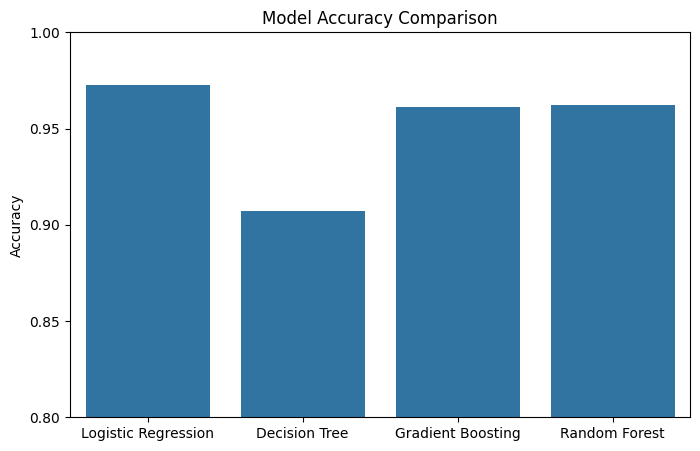

In [11]:
# Plot Accuracy among Models
models = ['Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'Random Forest']
accuracies = [
    lr.score(xv_test, y_test),
    dtc.score(xv_test, y_test),
    gclf.score(xv_test, y_test),
    rclf.score(xv_test, y_test)
]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies)
plt.ylim(0.8, 1.0)
plt.yticks([0.8, 0.85, 0.9, 0.95, 1.0])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [21]:
# Model Testing Analysis:
# The Logistic Regression model, Gradient Boosting Classifier Model, and Random Forest Classifier model all have an accuracy greater than 95%, 
# which are significantly better than the Decision Tree Classifier Model, which has an accuracy of about 90%.

In [13]:
# Map and return a human-readable label
def output_label(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not Fake News"

# Test predictions of all 4 models on custom input
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    
    pred_LR = lr.predict(new_xv_test)
    pred_DT = dtc.predict(new_xv_test)
    pred_GBC = gclf.predict(new_xv_test)
    pred_RFC = rclf.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nGBC Prediction: {} \nRFC Prediction: {}".format(output_label(pred_LR[0]),
                                                                                                              output_label(pred_DT[0]), 
                                                                                                              output_label(pred_GBC[0]), 
                                                                                                              output_label(pred_RFC[0])))

In [14]:
test_cases = [
    "Government launches new healthcare initiative.",
    "Scientists claim to have found life on Mars!",
    "This article is a hoax to trick you."
]

for article in test_cases:
    manual_testing(article)



LR Prediction: Not Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News


In [15]:
# Web Scraping From Online News Articles

# Reuters webscraping
def scrape_reuters():
    url = "https://www.reuters.com"
    headlines = []
    try:
        res = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(res.content, 'html.parser')
        for li in soup.find_all("li"):
            tag = li.find("span")
            if tag:
                text = tag.get_text(strip=True)
                if len(text) > 40 and len(text.split()) > 5:
                    headlines.append(text)
    except Exception as e:
        print(f"[Reuters] Error: {e}")
    return headlines[:5]

# CNN webscraping
def scrape_cnn():
    url = "https://www.cnn.com"
    headlines = []
    try:
        res = requests.get(url)
        soup = BeautifulSoup(res.content, "html.parser")
        for tag in soup.find_all(['h2', 'span']):
            text = tag.get_text(strip=True)
            if len(text) > 40 and len(text.split()) > 5:
                headlines.append(text)
    except Exception as e:
        print(f"[CNN] Error: {e}")
    return headlines[:5]

# BBC webscraping
def scrape_bbc():
    url = "https://www.bbc.com"
    headlines = []
    try:
        res = requests.get(url)
        soup = BeautifulSoup(res.content, "html.parser")
        for tag in soup.find_all(['h3', 'h2']):
            text = tag.get_text(strip=True)
            if len(text) > 40 and len(text.split()) > 5:
                headlines.append(text)
    except Exception as e:
        print(f"[BBC] Error: {e}")
    return headlines[:5]

# Test scraped news article headlines
def test_scraped_headlines():
    sources = {
        "Reuters": scrape_reuters(),
        "CNN": scrape_cnn(),
        "BBC": scrape_bbc()
    }

    for source, headlines in sources.items():
        print(f"\n==== {source} Headlines ====")
        for idx, headline in enumerate(headlines, 1):
            print(f"\n{idx}. {headline}")
            manual_testing(headline)

test_scraped_headlines()


==== Reuters Headlines ====

==== CNN Headlines ====

1. Kushner has been advising Trump officials on expanding Abraham Accords


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News

2. The president’s son-in-law, a chief Middle East negotiator in Trump’s first term, has informally been advising officials on talks, sources say


LR Prediction: Not Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Not Fake News

3. Stephen Miller says White House is ‘actively looking at’ suspending habeas corpus


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News

4. Why Trump just publicly negotiated with himself over China’s tariffs


LR Prediction: Fake News 
DT Prediction: Fake News 
GBC Prediction: Fake News 
RFC Prediction: Fake News

5. From an exclusive Pence interview to the pope, follow Kaitlan Collins’ week


LR Prediction: Fake News 
DT Prediction: Fake N

In [20]:
# Analysis of webscraping:
# Tests on online news sites worked only if the webpage has static HTML for news headlines. If it is loaded dynamically by Javascript,
# like Reuters' website, headlines cannot be scraped using our methods and needs to consider Javascript rendering.

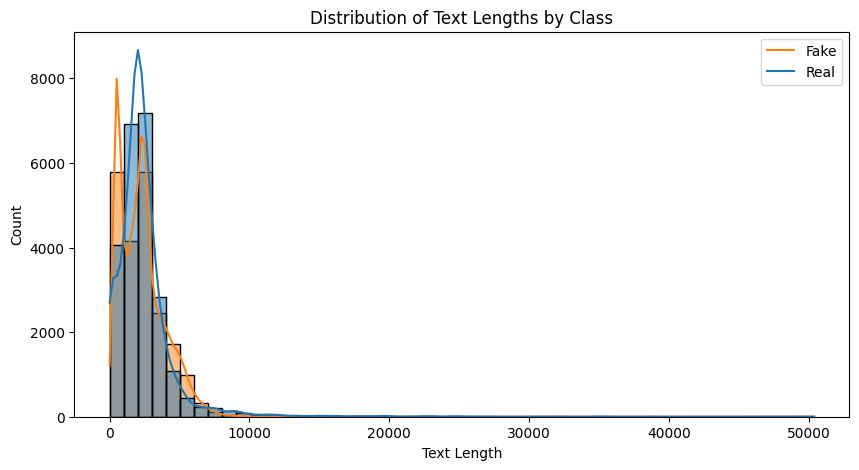

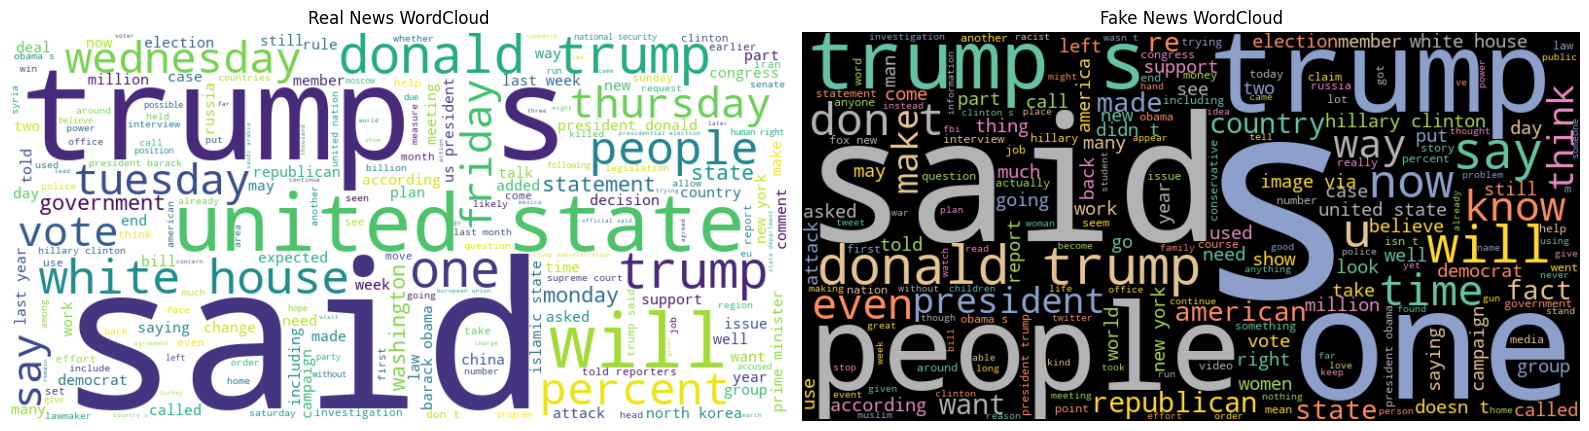

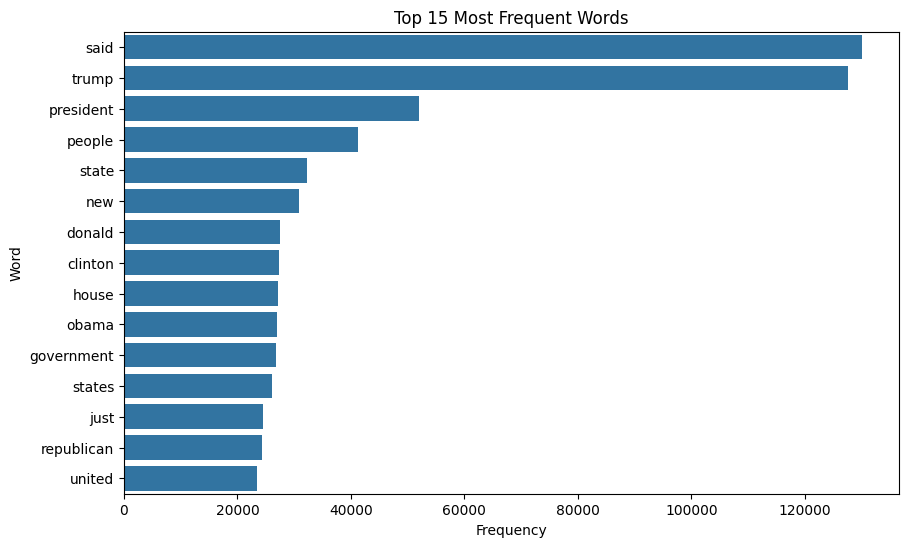

In [17]:
# Distribution of text lengths by class (real vs fake)
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='text_length', hue='target', bins=50, kde=True)
plt.title('Distribution of Text Lengths by Class')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.legend(['Fake', 'Real'])
plt.show()

# Combine all words by class
real_words = ' '.join(df[df['target'] == 1]['text'])
fake_words = ' '.join(df[df['target'] == 0]['text'])

# Generate Word Clouds for each class
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_words)
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(fake_words)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Real News WordCloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Fake News WordCloud')
plt.axis('off')

plt.tight_layout()
plt.show()

# Plot top N words by frequency
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

top_words = get_top_n_words(df['text'], 15)
top_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=top_df)
plt.title('Top 15 Most Frequent Words')
plt.show()


Prediction: Fake News
Probability it's real: 0.3285
Probability it's fake: 0.6715

Top words indicating REAL news:
this: -5.0295
is: -4.9145
via: -4.7199
that: -4.5566
just: -3.5490
you: -3.5134
image: -3.1975
hillary: -3.1719
obama: -2.9910
gop: -2.7974

Top words indicating FAKE news:
said: 15.7981
on: 7.6340
us: 4.9751
washington: 4.7885
in: 4.7561
tuesday: 3.6942
wednesday: 3.6881
minister: 3.5429
thursday: 3.4000
told: 3.3663


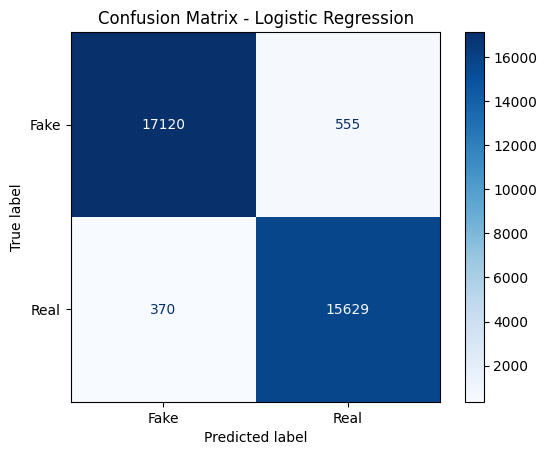


--- False Negatives (Real predicted as Fake) ---

rome   mamadu bassir sits eating a breakfast of warm milk and cookies in a migrants shelter in rome  one of nearly  lone youngsters who have survived the perilous sea journey from north africa to italy in the past four years his meal finished the gangly  tells the story of his trip from guinea via a libyan prison where a guard knocked out three of his teeth with a club to his crossing of the mediterranean where he watched a friend drown in front of him both fell into the water as migrants scrabb
------------------------------------------------------------

washington   the us supreme court on tuesday wrestled with the question of under what circumstances judges can recall jurors to duty after they have rendered a verdict in a case involving a man seeking damages after suffering injuries in a montana car accident the justices during an hour of arguments indicated that a gap of just a few minutes in which there is no opportunity for juro

In [19]:
# Diagnostic script for Fake News Detection

# 1. CONFIDENCE SCORES
def show_prediction_confidence(news):
    processed_text = wordopt(news)
    transformed_text = vectorization.transform([processed_text])
    probs = lr.predict_proba(transformed_text)
    print(f"\nPrediction: {output_label(lr.predict(transformed_text)[0])}")
    print(f"Probability it's real: {probs[0][1]:.4f}")
    print(f"Probability it's fake: {probs[0][0]:.4f}")

# 2. FEATURE IMPORTANCE
def print_top_features():
    feature_names = vectorization.get_feature_names_out()
    coefficients = lr.coef_[0]
    top_fake_idx = np.argsort(coefficients)[-10:]
    top_real_idx = np.argsort(coefficients)[:10]

    print("\nTop words indicating REAL news:")
    for i in top_real_idx:
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")

    print("\nTop words indicating FAKE news:")
    for i in reversed(top_fake_idx):
        print(f"{feature_names[i]}: {coefficients[i]:.4f}")

# 3. CONFUSION MATRIX
def plot_confusion_matrix():
    y_pred = lr.predict(xv_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.show()

# 4. MISCLASSIFIED EXAMPLES
def show_misclassified_examples():
    y_pred = lr.predict(xv_test)
    false_negatives = x_test[(y_test == 1) & (y_pred == 0)]  # Real predicted as Fake
    false_positives = x_test[(y_test == 0) & (y_pred == 1)]  # Fake predicted as Real

    print("\n--- False Negatives (Real predicted as Fake) ---")
    for article in false_negatives.sample(3, random_state=1):
        print(f"\n{article[:500]}\n{'-'*60}")

    print("\n--- False Positives (Fake predicted as Real) ---")
    for article in false_positives.sample(3, random_state=1):
        print(f"\n{article[:500]}\n{'-'*60}")

# 5. FULL DIAGNOSTIC FUNCTION
def run_full_diagnostics(news_input):
    show_prediction_confidence(news_input)
    print_top_features()
    plot_confusion_matrix()
    show_misclassified_examples()

# Example usage:
run_full_diagnostics("NASA confirms discovery of water on the sunlit surface of the Moon")
